In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from obspy.core.event import read_events
import obspy
import eqcorrscan
import eqcorrscan.core.match_filter.template as template
from obspy.clients.fdsn.client import Client
from eqcorrscan.core.template_gen import template_gen
from eqcorrscan import Tribe
from datetime import datetime

In [102]:
party = eqcorrscan.core.match_filter.party.Party().read('detections_sep2017/party_09_01_2019.tgz')
client = Client('IRIS')

In [371]:
path = 'detections_sep2017/'
t1 = datetime(2017,9,1)
t2 = datetime(2017,11,1)

In [415]:
def read_detections(path,t1,t2):
    
    time_bins = pd.to_datetime(np.arange(t1,t2,pd.Timedelta(1,'days')))
    
    parties = []
    for t in time_bins:
        pfile = path + 'party_' + t.strftime('%m_%d_%Y') + '.tgz'
        party = eqcorrscan.core.match_filter.party.Party().read(pfile)
        if len(party.families) > 0:
            parties.append(party)
        else:
            print('Detection did not work on ' + t.strftime('%m_%d_%Y'))

    # Combine the results from separate days into one party
    families = []
    num_templates = len(parties[0].families)
    for i in range(num_templates):
        fam_list = [p[i] for p in parties]
        fam = fam_list[0]
        for f in fam_list[1:]:
            fam = fam.append(f)
        families.append(fam)
    party = eqcorrscan.core.match_filter.party.Party(families=families)
    
    return party

In [289]:
party = eqcorrscan.core.match_filter.party.Party().read('detections_sep2017/party_09_03_2017.tgz')

Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks


In [416]:
party = read_detections(path,t1,t2)

Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks


Detection did not work on 09_04_2017


Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origi

Detection did not work on 09_11_2017


Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origi

Detection did not work on 10_14_2017
Detection did not work on 10_15_2017


Could not compute relative origin: no picks
Could not compute relative origin: no picks


Detection did not work on 10_19_2017


Could not compute relative origin: no picks
Could not compute relative origin: no picks
Could not compute relative origin: no picks


Detection did not work on 10_28_2017


Could not compute relative origin: no picks


In [401]:
for f in party:
    print(f)

Family of 1 detections from template growclust5_ev520234
Family of 1 detections from template growclust6_ev520343
Family of 1 detections from template growclust8_ev519836
Family of 1 detections from template growclust3_ev520909
Family of 1 detections from template growclust1_ev519970
Family of 0 detections from template growclust2_ev520643
Family of 0 detections from template growclust7_ev520826
Family of 1 detections from template growclust17_ev519551
Family of 1 detections from template growclust4_ev519904
Family of 6 detections from template growclust10_ev519520
Family of 2 detections from template growclust24_ev520672
Family of 1 detections from template growclust16_ev520891


#### Filter based on average channel cross correlation

In [400]:
# Remove detections with average cross correlation < 0.8

cc_thresh = 0.85

filtered_families = []
for family in party:
    keep = []
    for det in family:
        av_chan_corr = (det.detect_val/det.no_chans)
        if av_chan_corr > cc_thresh:
            keep.append(det)
    fam = eqcorrscan.core.match_filter.family.Family(family.template,detections=keep)
    filtered_families.append(fam)
    
party = eqcorrscan.core.match_filter.party.Party(families=filtered_families)

#### Filter based on cross correlation threshold

In [389]:
# Remove detections with threshold < 3.2, which is a good cut-off from visual inspection for truly similar waveforms

cc_thresh = 4

filtered_families = []
for family in party:
    keep = []
    for det in family:
        if det.detect_val > cc_thresh:
            keep.append(det)
    fam = eqcorrscan.core.match_filter.family.Family(family.template,detections=keep)
    filtered_families.append(fam)
    
party = eqcorrscan.core.match_filter.party.Party(families=filtered_families)

-3.2975106


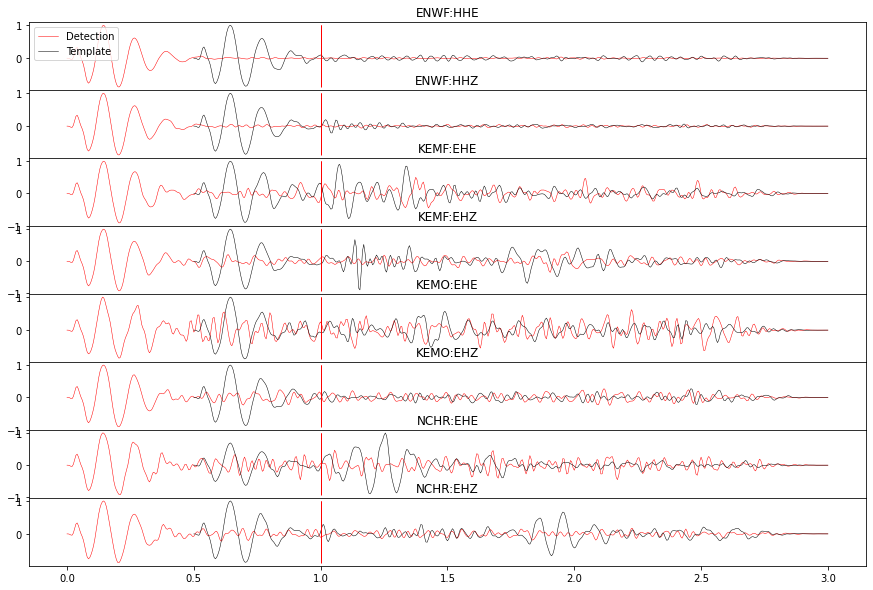

In [333]:
det = party[8].detections[3]
temp = party[8].template.event
print(det.detect_val)
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(len(det.event.picks), 1, gridspec_kw={'hspace': 0})
for i,pick in enumerate(det.event.picks):
    
    # New Detection
    t1 = pick.time-1
    t2 = pick.time+2
    sta_code = pick.waveform_id.station_code
    loc_code = pick.waveform_id.location_code
    chan_code = pick.waveform_id.channel_code
    st = client.get_waveforms("NV",sta_code,loc_code,chan_code,t1,t2)
    st.filter('bandpass',freqmin=8,freqmax=35)
    st = st.taper(max_percentage=0.2)
    st.normalize()
    l1, = axs[i].plot(st[0].times(),st[0].data,'r',linewidth=0.5,label='Detection') 
    axs[i].set_title(pick.waveform_id.station_code+':'+pick.waveform_id.channel_code)
    axs[i].vlines(x=1,ymin=min(st[0].data),ymax=max(st[0].data),colors ='r',linewidth=1)
    
    # Template waveform
    temp_stamatches = [temp_pick for temp_pick in temp.picks if temp_pick.waveform_id.station_code==sta_code]
    temp_pick = [temp_pick for temp_pick in temp_stamatches if temp_pick.waveform_id.channel_code==chan_code][0]
    t1 = temp_pick.time-0.5
    t2 = temp_pick.time+2
    st_temp = client.get_waveforms("NV",sta_code,loc_code,chan_code,t1,t2)
    st_temp.filter('bandpass',freqmin=8,freqmax=35)
    st_temp = st_temp.taper(max_percentage=0.2)
    st_temp.normalize()
    l2, = axs[i].plot(st_temp[0].times()+.5,st_temp[0].data,'k',linewidth = 0.5,label='Template') 
    axs[i].set_title(pick.waveform_id.station_code+':'+pick.waveform_id.channel_code)
    axs[i].vlines(x=1,ymin=min(st_temp[0].data),ymax=max(st_temp[0].data),colors ='r',linewidth=1)
    
    if i==0:
        axs[i].legend(handles=[l1, l2])


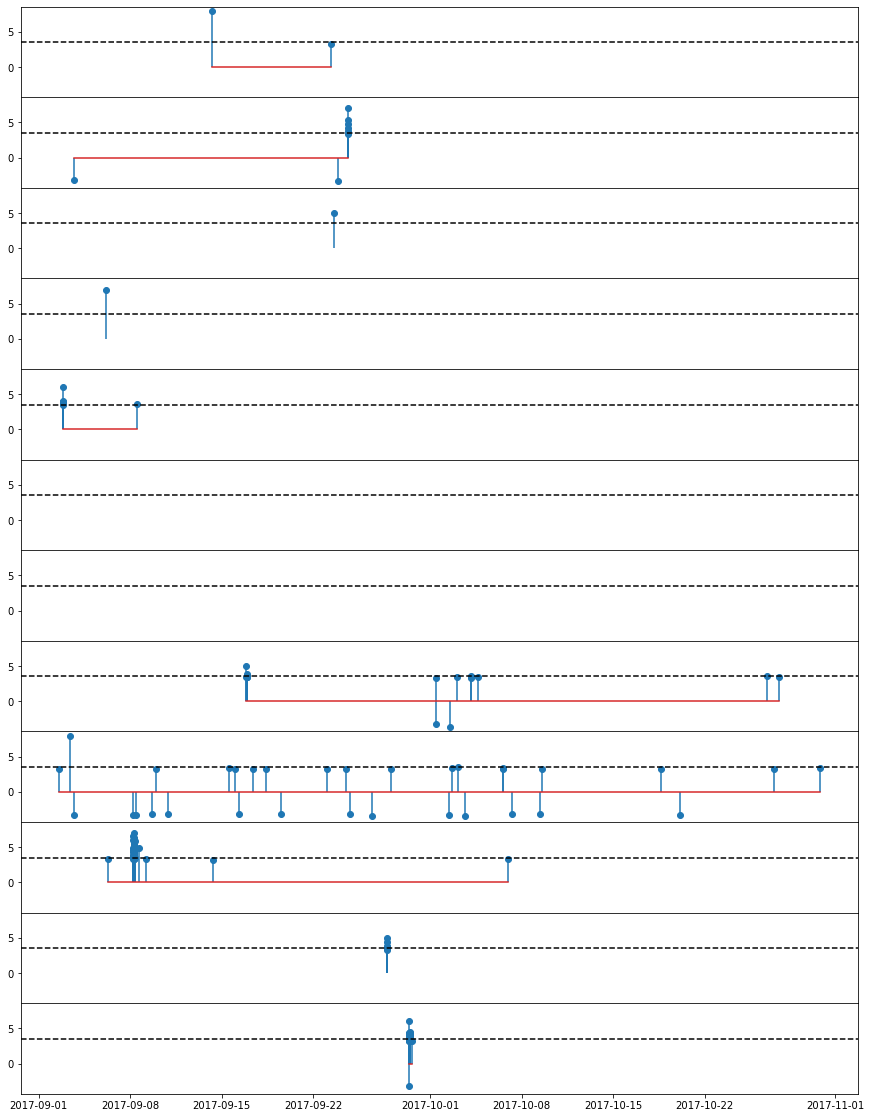

In [417]:
fig = plt.figure(figsize=(15, 20))
axs = fig.subplots(len(party.families), 1, gridspec_kw={'hspace': 0},sharey=True,sharex=True)

for i,family in enumerate(party):
    times = [detection.detect_time.datetime for detection in family.detections]
    vals = [detection.detect_val for detection in family.detections]
    
    if len(times) > 0:
        axs[i].stem(times,vals)
    axs[i].axhline(3.5,color='k',linestyle='--')

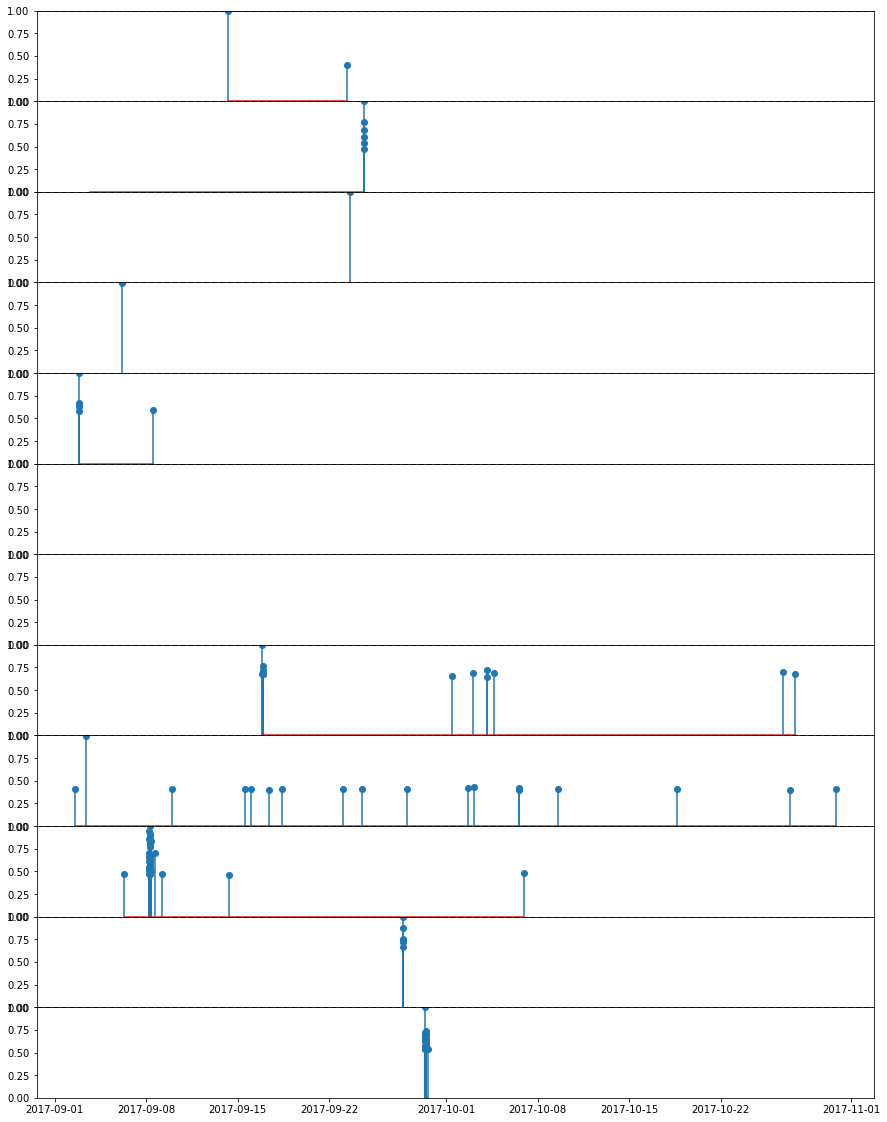

In [447]:
fig = plt.figure(figsize=(15, 20))
axs = fig.subplots(len(party.families), 1, gridspec_kw={'hspace': 0},sharey=True,sharex=True)

for i,family in enumerate(party):
    times = [detection.detect_time.datetime for detection in family.detections]
    vals = [detection.detect_val for detection in family.detections]
    thresh = [detection.threshold for detection in family.detections]
    chans = [detection.no_chans for detection in family.detections]
    av_chan_corrs = []
    for j,val in enumerate(vals):
        av_chan_corrs.append((vals[j]/chans[j]))
    
    if len(times) > 0:
        axs[i].stem(times,av_chan_corrs)
    axs[i].axhline(1,color='k',linestyle='--')
    axs[i].set_ylim(0,1)
    # axs[i].set_xlim(datetime(2017,9,8),datetime(2017,9,9))
    # axs[i].set_xlim(datetime(2017,9,24),datetime(2017,9,25))

## Biggest family - template 9

In [429]:
t1 = datetime(2017,9,8,4)
t2 = datetime(2017,9,8,9)
big_family = [d for d in party[9] if ((d.detect_time.datetime > t1) & (d.detect_time.datetime < t2))]

In [440]:
times = [d.detect_time for d in big_family]
interevent = np.diff(times)
print(np.mean(interevent)/60)
print(np.median(interevent)/60)

4.5155087719298255
1.5099583333333333


## Smallest family - template 1

In [445]:
party[1]
times = [d.detect_time for d in party[1]]
interevent = np.diff(times)
print(np.mean(interevent)/60)
print(np.median(interevent)/60)

4330.736071428571
0.6795833333333333


In [446]:
times

[2017-09-03T16:01:05.740000Z,
 2017-09-23T21:39:15.105000Z,
 2017-09-24T17:13:35.700000Z,
 2017-09-24T17:13:38.045000Z,
 2017-09-24T17:13:52.365000Z,
 2017-09-24T17:13:54.070000Z,
 2017-09-24T17:14:34.845000Z,
 2017-09-24T17:16:14.890000Z]

## Method to remove duplicates- which likely won't be an issue anymore with the new detection threshold parameters

In [ ]:
# Take the first family as all correct
# Then, one by one, go through the rest of the families and compare them to the first family
f1_times = [detection.detect_time for detection in party[0].detections]
for i,detection in enumerate(party[1].detections):
    time_diff = [f1_time - detection.detect_time for f1_time in f1_times]
    if np.abs(time_diff).min() < 5:
        print('Different by ' + str(np.abs(time_diff).min()) + ' seconds')
        print(i)
        print(np.abs(time_diff).argmin())